In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("C:\\Users\\hp\\Downloads\\gold_monthly_csv.csv")
df.head()


,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [47]:
df.shape

(847, 2)

In [48]:
print(f"Date range of gold prices available from {df.loc[:, 'Date'][0]} to {df.loc[:, 'Date'][len(df)-1]}")

Date range of gold prices available from 1950-01 to 2020-07


In [49]:
df['month'] = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
df.drop("Date", axis=1, inplace=True)
df = df.set_index('month')


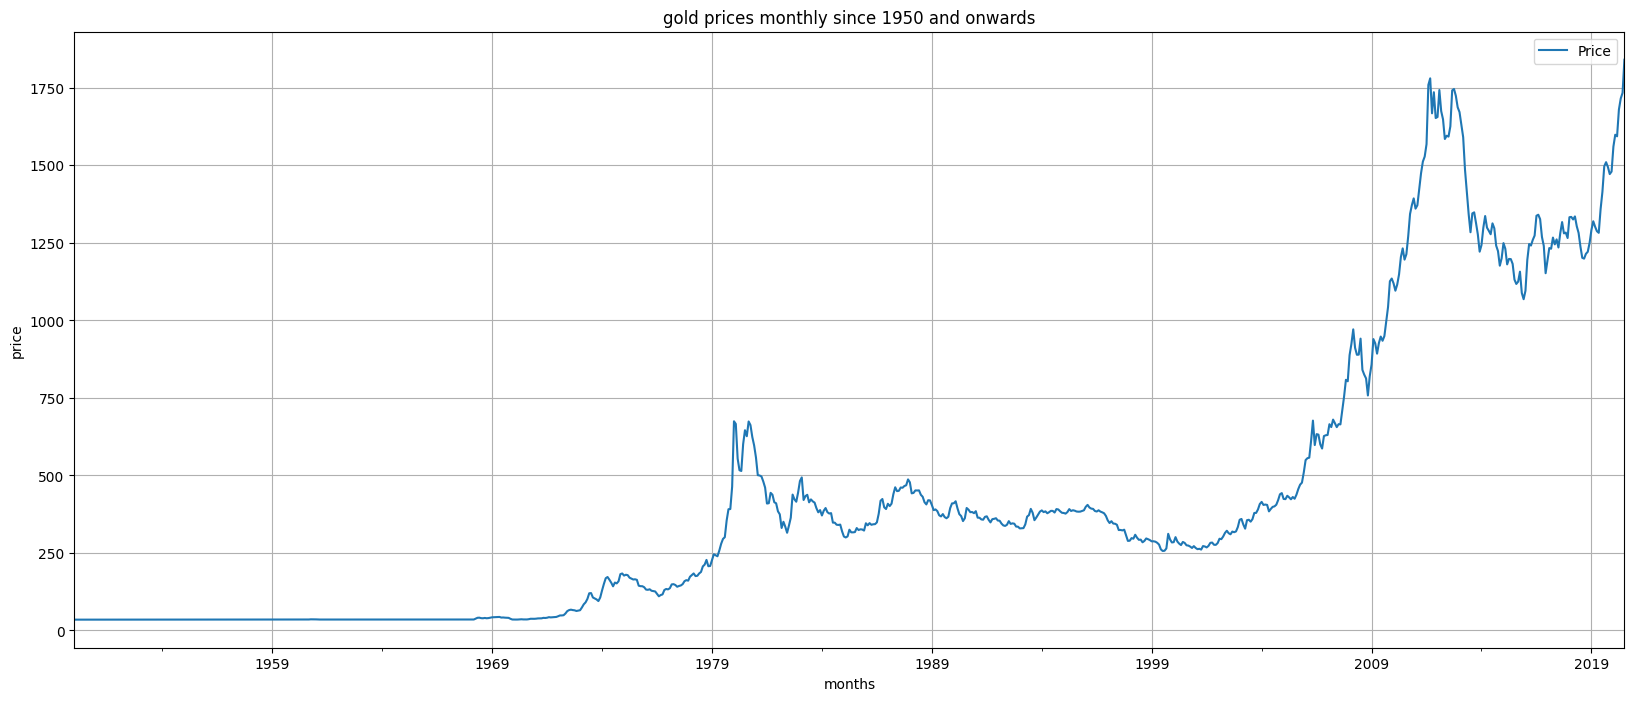

In [50]:
df.plot(figsize=(20,8))
plt.title("gold prices monthly since 1950 and onwards")
plt.xlabel("months")
plt.ylabel("price")
plt.grid();


In [51]:
round(df.describe(), 3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


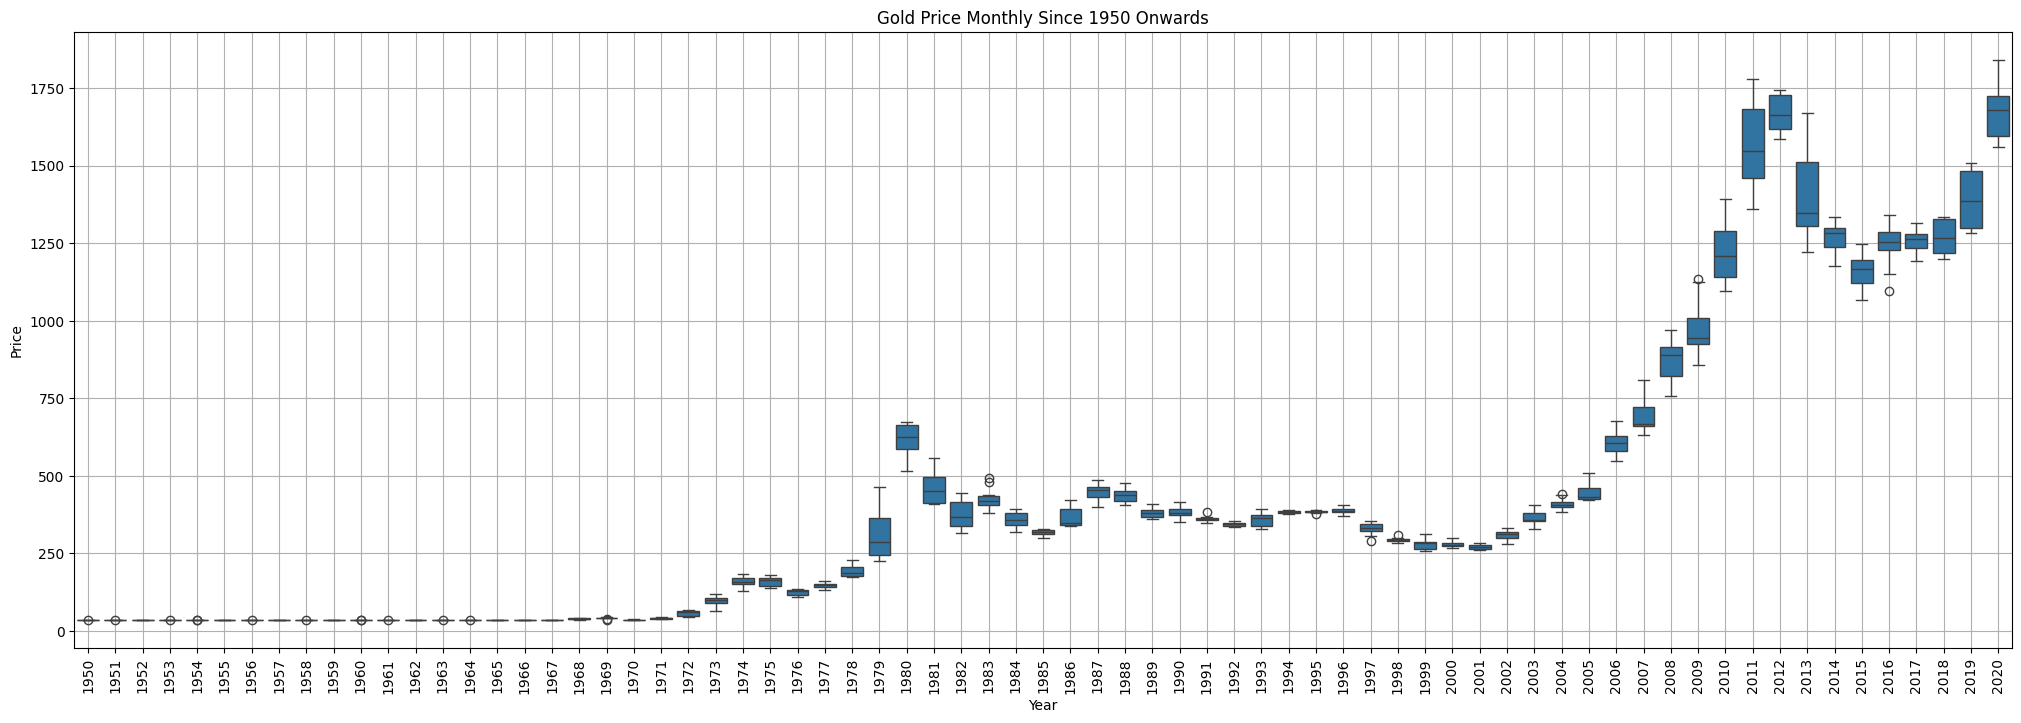

In [52]:
fig, ax = plt.subplots(figsize=(25, 8))
sns.boxplot(x=df.index.year, y=df['Price'], ax=ax)
ax.set_title('Gold Price Monthly Since 1950 Onwards')
ax.set_xlabel("Year")
ax.set_ylabel("Price")
plt.xticks(rotation=90)
ax.grid()
plt.show()

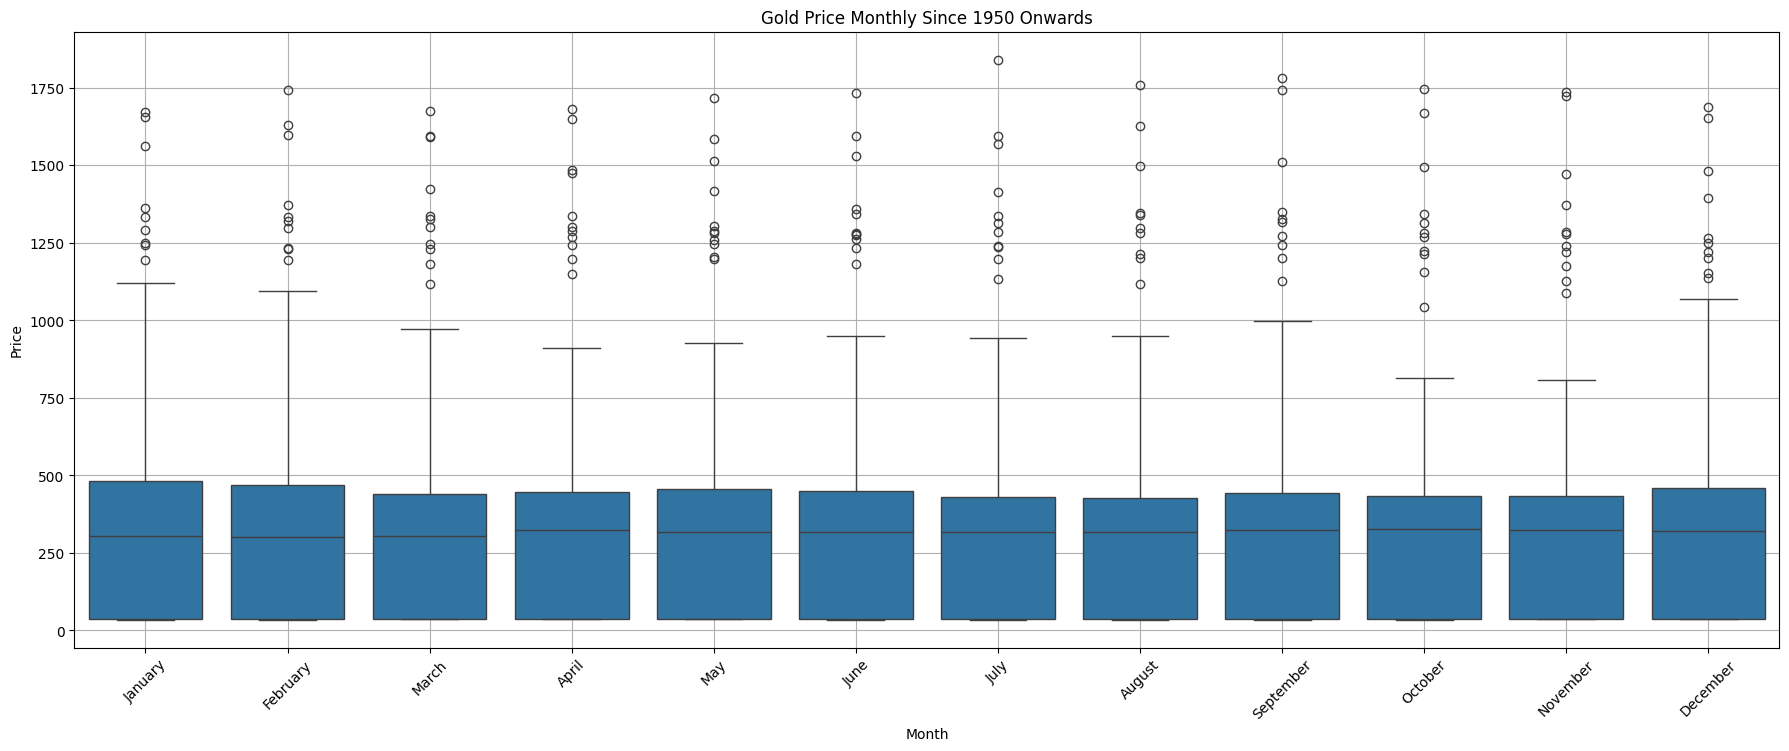

In [53]:
df['Month'] = df.index.month_name()
df['Month'] = pd.Categorical(df['Month'], categories=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
], ordered=True)

fig, ax = plt.subplots(figsize=(22, 8))
sns.boxplot(x='Month', y=df.iloc[:, 0], data=df, ax=ax)
ax.set_title('Gold Price Monthly Since 1950 Onwards')
ax.set_xlabel("Month")
ax.set_ylabel("Price")
plt.xticks(rotation=45)
plt.grid()
plt.show()

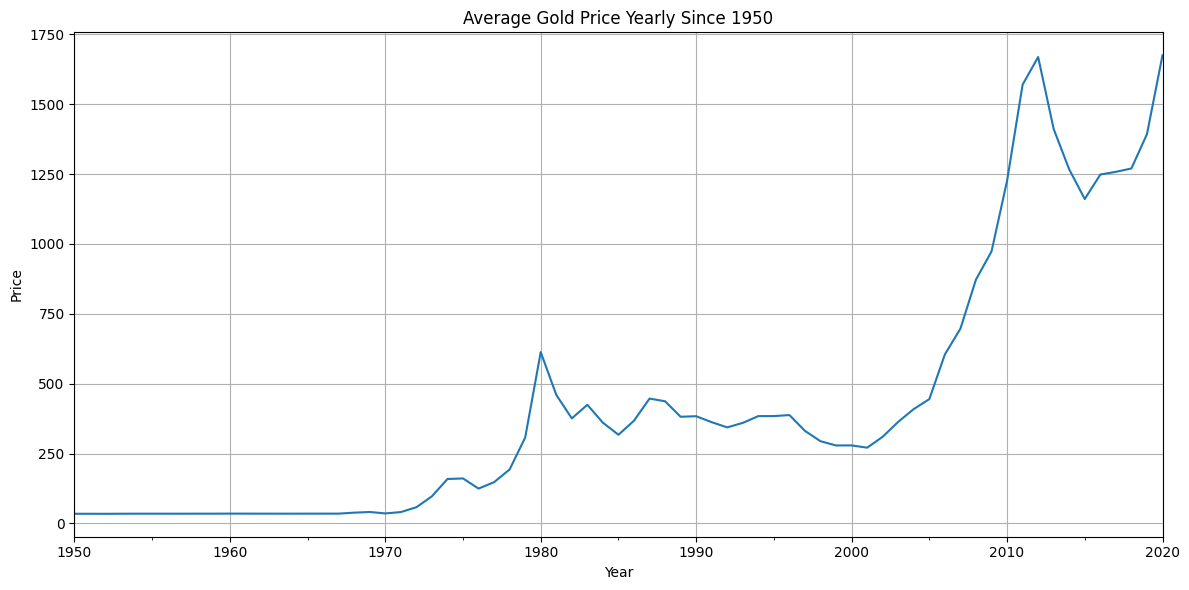

In [54]:
df_numeric = df.select_dtypes(include='number')
df_yearly_avg =df_numeric.resample('A').mean()
df_yearly_avg.plot(figsize=(12, 6), legend=False)
plt.title("Average Gold Price Yearly Since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


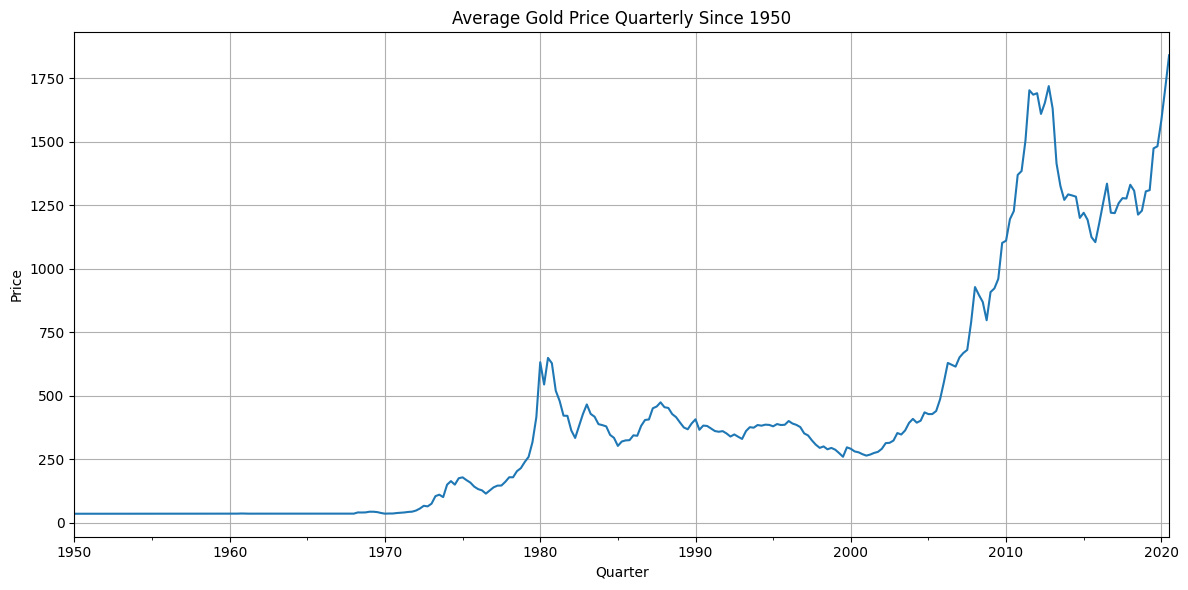

In [55]:
df_numeric = df.select_dtypes(include='number')
df_quarterly_avg = df_numeric.resample('Q').mean()
df_quarterly_avg.plot(figsize=(12, 6), legend=False)
plt.title("Average Gold Price Quarterly Since 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()


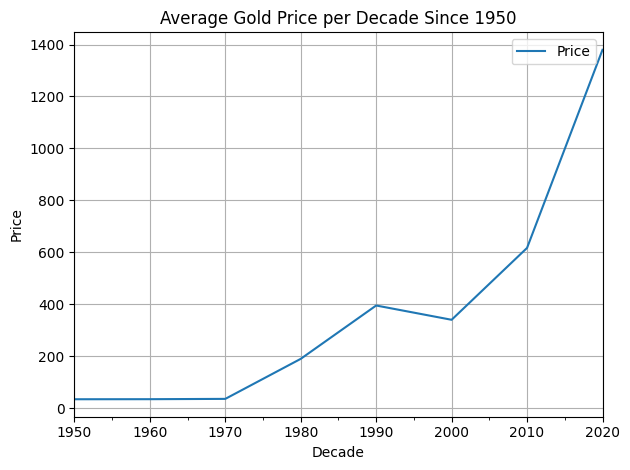

In [56]:
df_numeric = df.select_dtypes(include='number')
df_decade_avg = df_numeric.resample('10Y').mean()
df_decade_avg.plot()#figsize=(12, 6), legend=False to get graph like above
plt.title("Average Gold Price per Decade Since 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

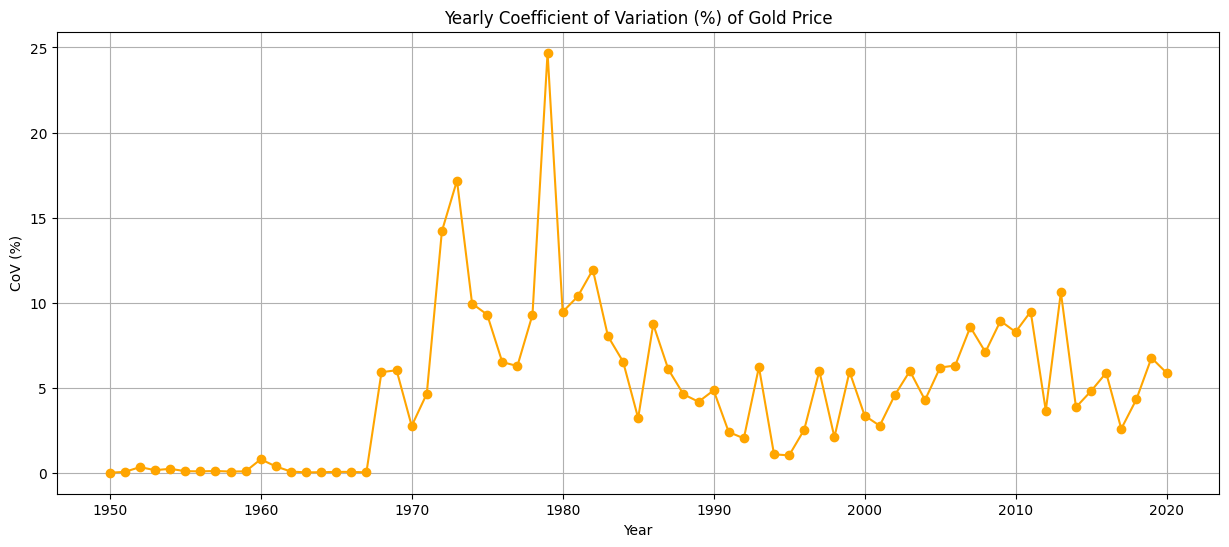

In [57]:
df.index = pd.to_datetime(df.index)
df_1 = df.groupby(df.index.year).agg(
    Mean=("Price", "mean"),
    Std=("Price", "std")
)
df_1["Cov_pct"] = (df_1["Std"] / df_1["Mean"]) * 100
df_1 = df_1.round(2)
fig, ax = plt.subplots(figsize=(15, 6))
df_1['Cov_pct'].plot(ax=ax, color='orange', marker='o')
plt.title("Yearly Coefficient of Variation (%) of Gold Price")
plt.xlabel("Year")
plt.ylabel("CoV (%)")
plt.grid()
plt.show()

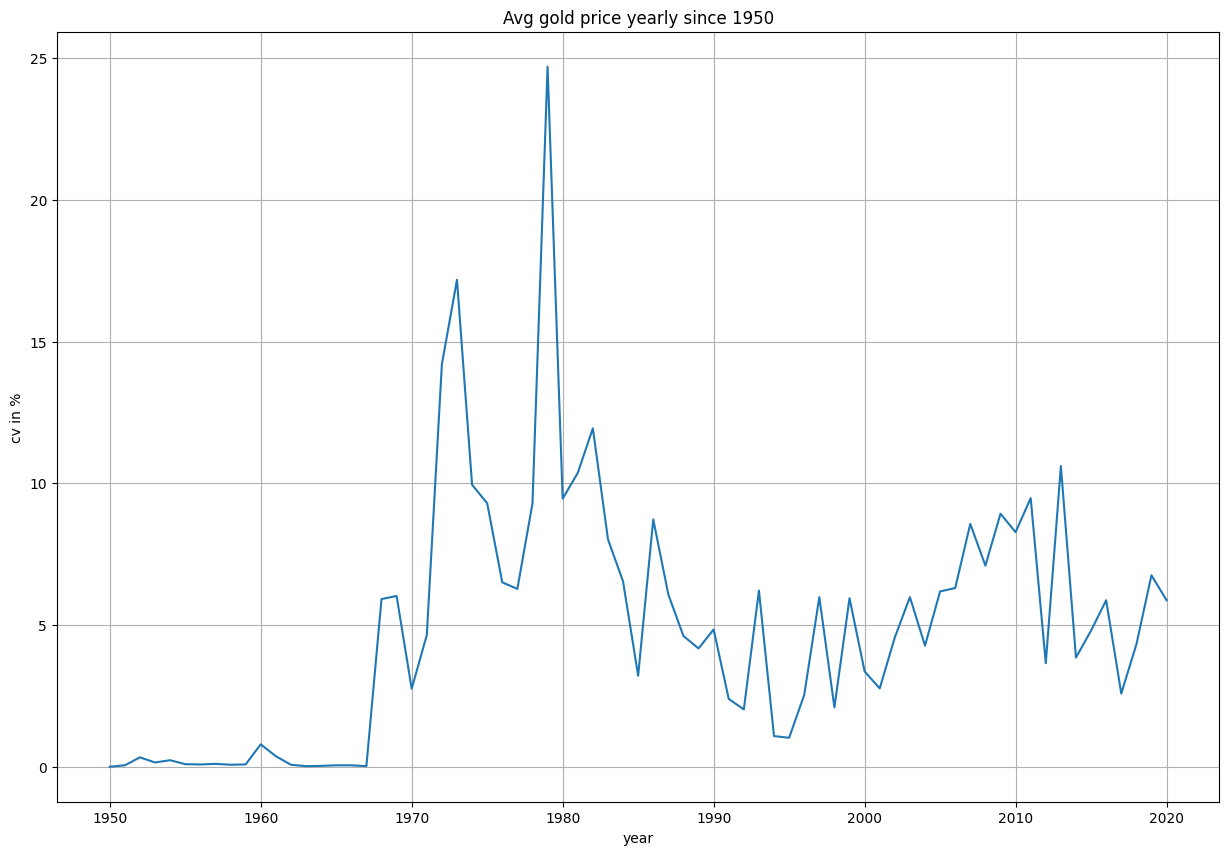

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
df_1['Cov_pct'].plot()
plt.title("Avg gold price yearly since 1950")
plt.xlabel('year')
plt.ylabel('cv in %')
plt.grid()


In [59]:
train = df[df.index.year <= 2015]
test = df[df.index.year > 2015]
print(train.shape)
print(test.shape)

(792, 2)
(55, 2)


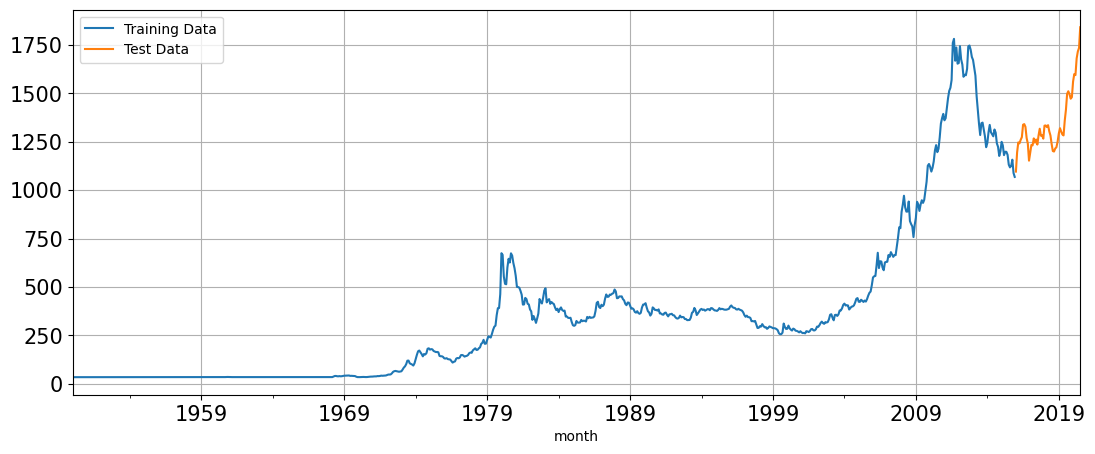

In [60]:
train["Price"].plot(figsize=(13, 5), fontsize=15)
test["Price"].plot(figsize=(13, 5), fontsize=15)
plt.grid()
plt.legend(['Training Data', 'Test Data'])
plt.show()

In [61]:
LR_train = train.copy()
LR_test = test.copy()
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
LR_train['time'] = train_time
LR_test['time'] = test_time


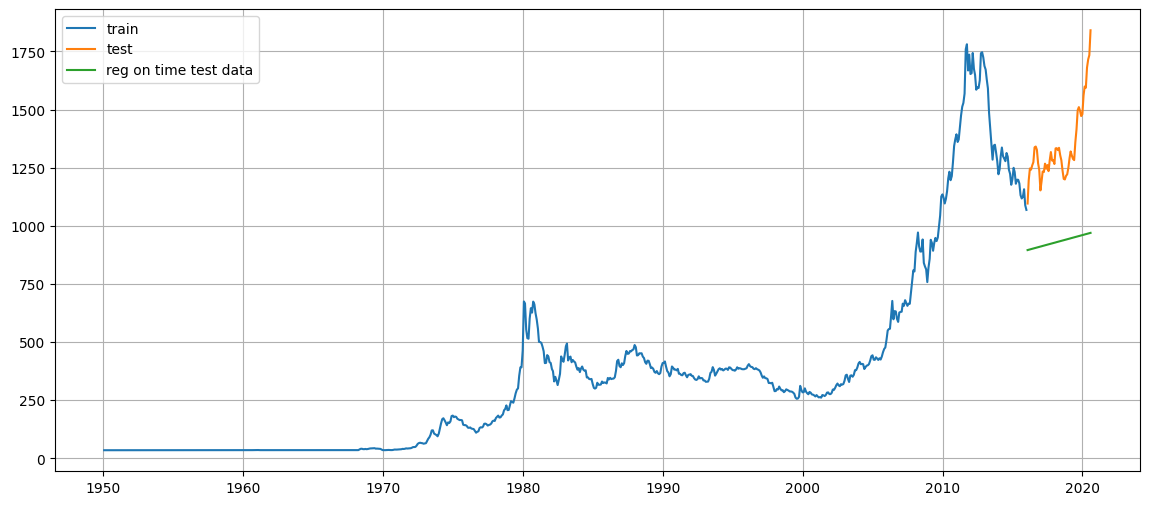

In [62]:
model1 = LinearRegression()
model1.fit(LR_train[['time']], LR_train["Price"].values)
test_predictions_model1 = model1.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize=(14, 6))
plt.plot(train["Price"], label='train')
plt.plot(test["Price"], label='test')
plt.plot(LR_test['forecast'], label='reg on time test data')
plt.legend(loc='best')
plt.grid()


In [63]:
def mape(actual, pred):
    return round((np.mean(abs(actual - pred) / actual)) * 100, 2)


In [64]:
mape_model1_test = mape(test['Price'].values, test_predictions_model1)
print("MAPE is %3.3f" % (mape_model1_test), "%")

results = pd.DataFrame({'Test MAPE (%)': [mape_model1_test]}, index=["RegressionOnTime"])
results


MAPE is 29.760 %


,Test MAPE (%)
RegressionOnTime,29.76


In [65]:
print(test.columns)

Index(['Price', 'Month'], dtype='object')


In [66]:
last_train_value = train['Price'].iloc[-1]  # last known value
test['naive'] = last_train_value  # naive forecast is constant

In [67]:
mape_model2_test = mape(test['Price'].values, test['naive'].values)
print("For Naive forecast on the Test Data, MAPE is %3.3f" % (mape_model2_test), "%")

resultsDf_2 = pd.DataFrame({'Test MAPE (%)': [mape_model2_test]}, index=["NaiveModel"])
results = pd.concat([results, resultsDf_2])
results


For Naive forecast on the Test Data, MAPE is 19.380 %


,Test MAPE (%)
RegressionOnTime,29.76
NaiveModel,19.38


In [69]:
df = df.copy()
df = df[['Price']]
df.index = pd.to_datetime(df.index)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.dropna()
seasonal_periods = 12  

final_model = ExponentialSmoothing(df,
                                    trend='additive',
                                    seasonal='additive').fit(
    smoothing_level=0.4,
    smoothing_trend=0.3,
    smoothing_seasonal=0.6)

MAPE_final_model = mape(df['Price'].values, final_model.fittedvalues)
print("MAPE:", MAPE_final_model)


MAPE: 17.24


In [70]:
predictions = final_model.forecast(steps=len(test))
pred_df = pd.DataFrame({
    'lower CI': predictions - 1.96 * np.std(final_model.resid, ddof=1),
    'prediction': predictions,
    'upper CI': predictions + 1.96 * np.std(final_model.resid, ddof=1)
})
pred_df.head()


,lower CI,prediction,upper CI
2020-08-31,1684.720065,1792.871037,1901.022009
2020-09-30,1615.306077,1723.457050,1831.608022
2020-10-31,1538.567922,1646.718895,1754.869867
2020-11-30,1476.758600,1584.909572,1693.060545
2020-12-31,1459.327290,1567.478262,1675.629235


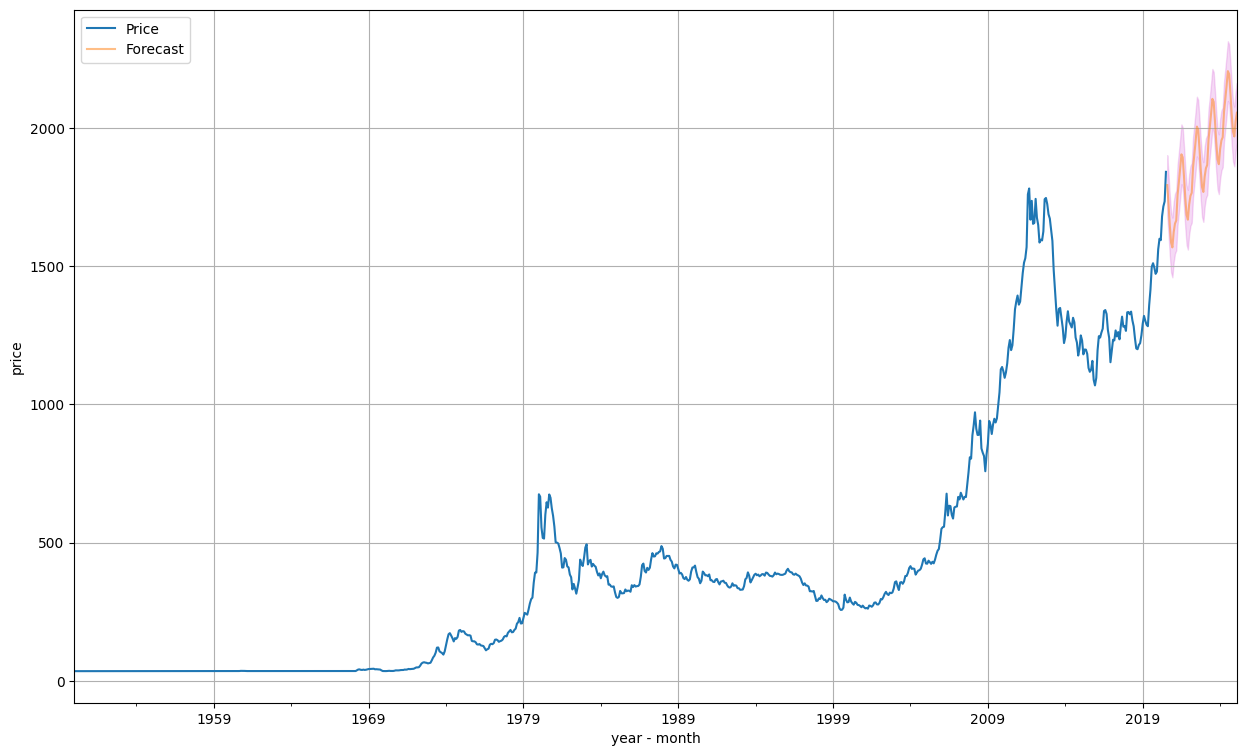

In [73]:
axis = df.plot(label='Actual', figsize=(15, 9))
pred_df['prediction'].plot(ax=axis, label='Forecast', alpha=0.5)
axis.set_ylabel('price')
axis.fill_between(pred_df.index, pred_df['lower CI'], pred_df['upper CI'], color='m', alpha=.15)
axis.set_xlabel('year - month')
plt.legend(loc='best')
plt.grid()
